### Load the dependencies


In [1]:
import os
import sys
import math
import psutil
os.environ["_CCTRACE_"]="ON"
import cloudComPy as cc
from gendata import getSampleCloud, dataDir
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import laspy
import tqdm
from time import sleep
from pathlib import Path
import multiprocessing
print("Main : Libs loaded")

Main : Libs loaded


#### Functions

In [ ]:
def convertLasTxt(pathToFile : str, nameOfFileOutput : str = "myCloud.txt") -> list:
    """convertLasTxt Converts .las file to .txt file for reading with cloudComPy.
    Note: it uses tqdm to show the progress of the conversion.

    Parameters
    ----------
    pathToFile : str
        _description_
    """
    listCoord_XYZ = np.empty([1,3])
    tmpList = []
    x:float = 0.0
    y:float = 0.0
    z:float = 0.0
    #! remark - path 2 has a lot of points, so it takes a while to read it (76_568_359 to be exact).
    with tqdm.tqdm(total=Path(pathToFile).stat().st_size) as pbar:
        with laspy.open(source = pathToFile) as cloudFileHeader:
            if type(cloudFileHeader) != None:
                cloudFile = laspy.read(source=pathToFile)
                try:
                    print("Cloud loaded")
                    print(f"cloud name:{cloudFile.header}")
                except:
                    print(f"cloud name:<unknown>")
                    
            #? It seems that chunk_iterator helps to read data in batches. In every batch it reads the data and then it moves to the next batch.
            #? Points.array is in fact a one point array. if we set chunk_iterator to (1)
            #? What is the data inside of the point? It must be x,y,z and something else. It is possible to extract x,y,z from the point. Is it enough data?
            for points in cloudFileHeader.chunk_iterator(1):
                print("points.array[0]['X'], points.array[0]['Y'], points.array[0]['Z']", points.array[0]['X'], points.array[0]['Y'], points.array[0]['Z'])
                x,y,z = points.array[0]['X'], points.array[0]['Y'], points.array[0]['Z']
                valuesToAppend = np.array([[x,y,z]])
                tmpList.append(valuesToAppend)
                # listCoord_XYZ = np.concatenate((listCoord_XYZ, valuesToAppend), axis=0)
                # np.append(arr = listCoord_XYZ, values= valuesToAppend , axis=0)
                pbar.update(n=1)
            listCoord_XYZ = np.array(tmpList) 
            pbar.close()
            np.savetxt(nameOfFileOutput, listCoord_XYZ, delimiter=" ", newline="\n")
            print(f"convertLasTxt _> File {nameOfFileOutput} saved")
    print("convertLasTxt _> Conversion finished")
    return listCoord_XYZ

# def giveSpherePath(x:float = 0, y:float = 0, z:float = 0 , r:float = 10, num:int = 100, dx:float = 0.1, h:float = 5):
#     """give_sphere Create a sphere point cloud
#     Parameters"""
#     dataDir = os.path.join(os.environ["USERPROFILE"], "CloudComPy/data")
#     print("dataDir: ", dataDir)
#     if not os.path.exists(dataDir):
#         os.makedirs(dataDir)
#     # points = []
#     # for i in range(0, num):
#     #     factor = stats.norm.pdf((np.arange(-5, 5, 0.001)), 0, 1)
#     #     # factor = normedgauss()        # A value between 0 and 1 following a gaussian
#     #     ir = r * factor
#     #     itheta = np.arccos(np.random.uniform(-1, 1))
#     #     iphi = np.random.uniform(0, 2 * np.pi)
#     #     ix = x + ir * np.sin(itheta) * np.cos(iphi)
#     #     iy = y + ir * np.sin(itheta) * np.sin(iphi)
#     #     iz = z + ir * np.cos(itheta)
#     #     points.append((ix, iy, iz))

#     dataName = "dataSample_%s.xyz" % h
#     if dx != 0:
#         dataName = "dataSample_%s_%s.xyz" % (h,dx)
#     sample = os.path.join(dataDir, dataName)
#     vx = np.array([])
#     vy = np.array([])
#     if not os.path.exists(sample):
#         print("Generating data: start X and Y!")
#         for i in range(0, num):
#             factor = stats.norm.pdf((np.arange(-5, 5, 0.001)), 0, 1)
#             ir = r * factor
#             itheta = np.arccos(np.random.uniform(-1, 1))
#             iphi = np.random.uniform(0, 2 * np.pi)
#             vx = np.append(arr = vx, values =  x + ir * np.sin(itheta) * np.cos(iphi))
#             vy = np.append(arr = vy, values = y + ir * np.sin(itheta) * np.sin(iphi))
#         print("Generating data: X and Y done!")

#         with open(sample, 'w') as f:
#             for xCoord in vx:
#                 for yCoord in vy:
#                     zCoord = math.sin(h * math.sqrt(xCoord**2 + yCoord**2)) / math.sqrt(xCoord**2 + yCoord**2)
#                     f.write("%f %f %f\n" % (xCoord, yCoord, zCoord))
#                 print("Generating data: Z done!")
#     return sample

def createShpereFull(number:int, center:list, radius:float, cutTheShape : bool = True) -> list:
    """createShpereFull It generates sphere point cloud (and points inside the volume) with a given center and radius.

    Parameters
    ----------
    number : int
        _description_
    center : list
        _description_
    radius : float
        _description_
    cutTheShape : bool, optional
        _description_, by default True

    Returns
    -------
    list
        _description_
    """
    # generate the random quantities
    phi         = np.random.uniform( 0, 2*np.pi, size=(number,))
    theta_cos   = np.random.uniform(-1,       1, size=(number,))
    u           = np.random.uniform( 0,       1, size=(number,))

    # calculate sin(theta) from cos(theta)
    theta_sin   = np.sqrt(1 - theta_cos**2)
    r           = radius * np.cbrt(u)

    # use list comprehension to generate the coordinate array without a loop
    # don't forget to offset by the atom's position (center)
    return np.array([
        np.array([
            center[0] + r[i] * theta_sin[i] * np.cos(phi[i]),
            center[1] + r[i] * theta_sin[i] * np.sin(phi[i]),
            center[2] + r[i] * theta_cos[i]
        ]) for i in range(number)
    ])

def createSpherePoints(radius:float = 5, number:int=10,  center:list = [0,0,0], cutTheShape : str = "None", leftTreshold : float = 1, rightTreshold : float = 1) -> list:
    """createSpherePoints It generates sphere point cloud without any points in the volume with a given center and radius.

    Parameters
    ----------
    radius : float, optional
        _description_, by default 5
    number : int, optional
        _description_, by default 10
    center : list, optional
        _description_, by default [0,0,0]
    cutTheShape : str, optional
        _description_, Cut the shape of the sphere according to GLOBAL coordinates.
    leftTreshold : float, optional
        _description_, by default 1
    rightTreshold : float, optional
        _description_, by default 1

    Returns
    -------
    list
        _description_
    """
    pi = math.pi
    sin = math.sin
    cos = math.cos
    lst = []
    for phi in [(pi*i)/(number-1) for i in range(number)]:
        M = int(sin(phi)*(number-1))+1
        for theta in [(2*pi*i)/M for i in range(M)]:
            x = center[0] + radius * sin(phi) * cos(theta)
            y = center[1] + radius * sin(phi) * sin(theta)
            z = center[2] + radius * cos(phi)
            if (cutTheShape == "left" and z<=leftTreshold):
                continue

            elif (cutTheShape == "right" and z>=rightTreshold):
                continue

            else:
                lst.append((x, y, z))

    return np.array(lst)
    # return np.array([
    #     np.array([
    #         center[0] + radius   * sin(phi) * cos(theta),
    #         center[1] + radius   * sin(phi) * sin(theta),
    #         center[2] + radius   * cos(phi)
    #     ]) for i in range(number)
    # ])



### Create testing geometry/data/PointCloud

In [ ]:
# sphereCoords1 = createSpherePoints(number=166, center=[0,0,0], radius=4, cutTheShape="left", leftTreshold = 1)
# sphereCoords2 = createSpherePoints(number=255, center=[0,0,7], radius=6, cutTheShape="right", rightTreshold =5)
# print(sphereCoords1.shape)
# print(sphereCoords1)
# print(sphereCoords2.shape)
# print(sphereCoords2)
# np.savetxt("testSphere_1.txt", sphereCoords1, delimiter=" ", newline="\n")
# np.savetxt("testSphere_2.txt", sphereCoords2, delimiter=" ", newline="\n")

### Paths to files/ meshes/ pointClouds

##### TODO - add a functionality to lead from CLI

In [ ]:
# path1 = r"C:\Users\szinp\Desktop\CloudComPy39_20220513\CloudCompPy_Computing-CloudPoint\testSphere_1.txt"
# path2 = r"C:\Users\szinp\Desktop\CloudComPy39_20220513\CloudCompPy_Computing-CloudPoint\testSphere_2.txt"
# path1 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\myCloud_1.txt"
# path2 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\myCloud_2.txt"
path1 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\txtFiles\1E.txt"
path2 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\txtFiles\2E.txt"
# path1 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\txtFiles\testSphere_1.txt"
# path2 = r"C:\Users\szinp\Desktop\lazorScan_project\testData\txtFiles\testSphere_2.txt"

assert os.path.isfile(path1)
assert os.path.isfile(path2)
print("Paths are correct")

## Load the data into CloudComPy module

In [ ]:
# gen.createSymbolicLinks() # required for tests on build, before cc.initCC.init
cc.initCC()
#TODO find a way to load a las file into this cloudComPy module natevly
#! Working with real data
cloud1 = cc.loadPointCloud(path1)
cloud2 = cc.loadPointCloud(path2)
#! Getting test clouds
# cloud1 = cc.loadPointCloud(getSampleCloud(1.0))
# cloud2 = cc.loadPointCloud(getSampleCloud(2.0))

cloud1.setName("cloud1")
cloud2.setName("cloud2")

### ICP registration

In [ ]:
# res=cc.ICP(data=cloud2, model=cloud1,  minRMSDecrease=1.e-5,
#            maxIterationCount=40,  randomSamplingLimit=50000, removeFarthestPoints=False, method=cc.CONVERGENCE_TYPE.MAX_ITER_CONVERGENCE, adjustScale=True, finalOverlapRatio=0.1)
# res=cc.ICP(data=cloud2, model=cloud1, minRMSDecrease=1.e-5,
#             randomSamplingLimit=50000,maxIterationCount=5000, removeFarthestPoints=False, method=cc.CONVERGENCE_TYPE.MAX_ITER_CONVERGENCE, adjustScale=True, finalOverlapRatio=1, maxThreadCount = 0)
res=cc.ICP(data=cloud2, model=cloud1, minRMSDecrease=1.e-5,
            randomSamplingLimit=50000,maxIterationCount=40, removeFarthestPoints=False, method=cc.CONVERGENCE_TYPE.MAX_ERROR_CONVERGENCE, adjustScale=True, finalOverlapRatio=0.90, maxThreadCount = 0)
# res=cc.ICP(data=cloud2, model=cloud1, minRMSDecrease=1.e-5,
#             randomSamplingLimit=50000,maxIterationCount=40, removeFarthestPoints=False, method=cc.CONVERGENCE_TYPE.MAX_ERROR_CONVERGENCE, adjustScale=False, finalOverlapRatio=0.90, maxThreadCount = 0)
tr2 = res.transMat
cloud2ICP = res.aligned
cloud2ICP.applyRigidTransformation(tr2)
cloud2ICP.setName("cloud2_transformed_afterICP")
# ICP(class ccHObject * __ptr64 data, class ccHObject * __ptr64 model, double minRMSDecrease, unsigned int maxIterationCount, unsigned int randomSamplingLimit, bool removeFarthestPoints, enum CCCoreLib::ICPRegistrationTools::CONVERGENCE_TYPE method, bool adjustScale, double finalOverlapRatio=1.0, bool useDataSFAsWeights=False, bool useModelSFAsWeights=False, int transformationFilters=_cloudComPy.TRANSFORMATION_FILTERS.SKIP_NONE, int maxThreadCount=0)

### Calculating Octree for the point cloud and distances

In [ ]:

# #? Octree does not show up in the CloudComapre software - might be a reason why M3C2 is not working correctly 
# nbCpu = psutil.cpu_count()
# bestOctreeLevel = cc.DistanceComputationTools.determineBestOctreeLevel(cloud1, None, cloud2ICP)


In [ ]:
# params = cc.Cloud2CloudDistancesComputationParams()
# params.maxThreadCount = nbCpu
# params.octreeLevel = bestOctreeLevel
# cc.DistanceComputationTools.computeCloud2CloudDistances(cloud1, cloud2ICP, params)

### Using M3C2 script to calculate the differences between the two clouds

#### Creating parameters for M3C2 script

In [ ]:
# ! Reading parameters form ready file for now
m3c2_params_dic={}
m3c2_params_dic["ExportDensityAtProjScale"] = "false"
m3c2_params_dic["ExportStdDevInfo"] = "false"
m3c2_params_dic["M3C2VER"] = 1
m3c2_params_dic["MaxThreadCount"] = multiprocessing.cpu_count()
m3c2_params_dic["MinPoints4Stat"] = 5
m3c2_params_dic["NormalMaxScale"] = 0.283607
m3c2_params_dic["NormalMinScale"] = 0.070902
m3c2_params_dic["NormalMode"] = 0
m3c2_params_dic["NormalPreferedOri"] = 4
m3c2_params_dic["NormalScale"] = 0.141803
m3c2_params_dic["NormalStep"] = 0.070902
m3c2_params_dic["NormalUseCorePoints"] = "false"
m3c2_params_dic["PM1Scale"] = 1
m3c2_params_dic["PM2Scale"] = 1
m3c2_params_dic["PositiveSearchOnly"] = "false"
m3c2_params_dic["ProjDestIndex"] = 1
m3c2_params_dic["RegistrationError"] = 0
m3c2_params_dic["RegistrationErrorEnabled"] = "false"
m3c2_params_dic["SearchDepth"] = 0.709017
m3c2_params_dic["SearchScale"] = 0.141803
m3c2_params_dic["SubsampleEnabled"] = "true"
m3c2_params_dic["SubsampleRadius"] = 0.070902
m3c2_params_dic["UseMedian"] = "false"
m3c2_params_dic["UseMinPoints4Stat"] = "false"
m3c2_params_dic["UseOriginalCloud"] = "false"
m3c2_params_dic["UsePrecisionMaps"] = "false"
m3c2_params_dic["UseSinglePass4Depth"] = "false"
paramFilename =os.path.abspath("") + "\dataFolder\PythonParameters\m3c2_params.txt"
# paramFilename =os.path.abspath("") + r'\dataFolder\PythonParameters\bigData_1_m3c2_params.txt'
print(f"Writing parameters to {paramFilename}")
assert os.path.isfile(paramFilename), "File does not exist"

# with open(paramFilename, 'w') as f:
#     f.write("[General]\n")
#     for k,v in m3c2_params_dic.items():
#         f.write("%s=%s\n"%(k,v))

### Running M3C2 script

In [ ]:
testNumber = 2

if cc.isPluginM3C2():
    import cloudComPy.M3C2
    print("M3C2 plugin is loaded, attempting to run M3C2")
    CloudAfterM3C2 = cc.M3C2.computeM3C2([cloud1,cloud2ICP], paramFilename)
    # CloudAfterM3C2 = cc.M3C2.computeM3C2([cloud2ICP,cloud1], paramFilename)
    print("M3C2 finished")
    print("type(CloudAfterM3C2)", type(CloudAfterM3C2))
    if CloudAfterM3C2 is None:
        raise RuntimeError
    if CloudAfterM3C2.getNumberOfScalarFields() < 3:
        raise RuntimeError
    dic= CloudAfterM3C2.getScalarFieldDic()
    sf = CloudAfterM3C2.getScalarField(dic['M3C2 distance'])
    if sf is None:
        raise RuntimeError
    # if not math.isclose(sf.getMax(), 0.71, rel_tol=0.01):
    #     raise RuntimeError
    # if not math.isclose(sf.getMin(), -0.70, rel_tol=0.01):
    #     raise RuntimeError
    # pathToSaveOutput = os.path.abspath("") + "\dataFolder\M3C2.bin"
    pathToSaveOutput = os.path.abspath("") + "\dataFolder\pythonScripts_testOutputs\\" + "bigData_test_%d_.las"%testNumber
    print(f"Saving results to {pathToSaveOutput}")
    cc.SavePointCloud(CloudAfterM3C2, pathToSaveOutput) # OK
    assert os.path.isfile(pathToSaveOutput)

    #TODO Las file saving, see


### Notes
```
Scipt takes about 57 minutes to execute on two data.txt cutted 3GB each

If the model presents some problems:
- Check if the path to params file is alright
- If you are getting weird white spaces without colors try increasing searchDepth in params file
- Resolution can be in m3c2_params.txt file. (Normals)
- check the model is not too small (less than 10 points)

```

TODO:
- Add a functionality to lead from CLI
- Change the output format (to be able to use with server side app) to .las
- Make a report with the results
- Build docker environment for the app on server
- make ssh key and send it to the server. Public key _> Done

In [ ]:
# if cc.isPluginM3C2():
#     import cloudComPy.M3C2
#     cloud = cc.loadPointCloud(getSampleCloud(5.0))
#     cloud1 = cc.loadPointCloud(getSampleCloud(1.0))
#     cloud2 = cc.M3C2.computeM3C2([cloud,cloud1], paramFilename)
    
#     if cloud2 is None:
#         raise RuntimeError
#     if cloud2.getNumberOfScalarFields() < 3:
#         raise RuntimeError
#     dic= cloud2.getScalarFieldDic()
#     sf = cloud2.getScalarField(dic['M3C2 distance'])
#     if sf is None:
#         raise RuntimeError
#     if not math.isclose(sf.getMax(), 0.71, rel_tol=0.01):
#         raise RuntimeError
#     if not math.isclose(sf.getMin(), -0.70, rel_tol=0.01):
#         raise RuntimeError
#     pathToSaveOutput = os.path.abspath("") + "\dataFolder\M3C2_test.bin"
#     cc.SaveEntities([cloud, cloud1, cloud2],pathToSaveOutput)

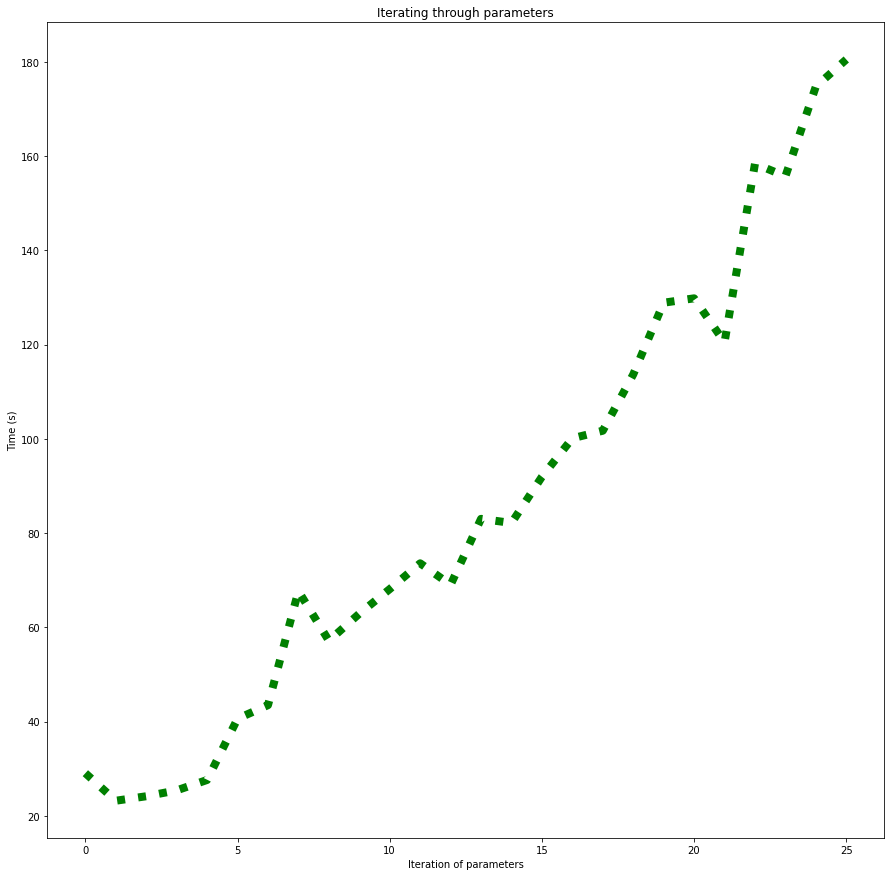

In [28]:
Time = [29.047122100000024,
23.200476800000047,
24.151861999999994,
25.402463599999976,
27.605965000000026,
40.613599799999974,
43.48064519999997,
67.6834255,
57.149287999999956,
62.884282700000085,
68.10861790000001,
73.57706070000006,
69.01486399999999,
83.01317669999992,
82.13274609999985,
91.9345338999999,
100.09876409999993,
101.70548800000006,
113.64610379999999,
128.86757809999995,
129.79869359999998,
120.46101849999991,
158.36929740000005,
155.68920890000027,
174.73613870000008,
180.47980580000012,]
plt.figure(figsize=(15,15))
plt.ylabel("Time (s)")
plt.xlabel("Iteration of parameters")
plt.title("Iterating through parameters")
plt.plot(Time,  label="Time taken to compute", color="green",  linestyle=':', linewidth='8')
plt.show()